In [734]:
import os
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import math

class NBClassifier:
    def __init__(self) -> None:
        self.vocab = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ']

        self.vectorizer = CountVectorizer(analyzer='char', vocabulary=self.vocab)
        
        self.training_data = None
        self.priors = {}
        self.model = self.get_training_data()
        self.summerize_cols()
        self.calculate_priors()

    def calculate_priors(self):
        predictions = []
        num_training_samples = 0
        for key, value in self.training_data.items():
            num_training_samples += len(value)

        for key, value in self.training_data.items():
            self.priors[key] = (len(value) * 1.0)/num_training_samples

    def get_training_data(self):
        training_data = {}

        files = os.listdir('./languageID')
        for file in files:
            file_name = file.split('.')[0]
            number = int(file_name[1:])

            if number >= 10:
                continue

            f = open(f"./languageID/{file}", 'r')
            if file[0] in training_data:
                training_data[file[0]].append(f.read())
            else:
                training_data[file[0]] = [f.read()]
            f.close()

        self.training_data = training_data

        training_vectorized = {}
        for key, value in training_data.items():
            X = self.vectorizer.fit_transform(value)
            training_vectorized[key] = {
                'data': X.A
            }

        return training_vectorized

    def summerize_cols(self):
            for key, value in self.model.items():
                stats = [] 
                data = value['data']
                for col_idx in range(data.shape[1]):
                    col = data[:, col_idx]
                    stats.append((col.mean(), col.std(), np.sum(col > 0)))

                self.model[key]['stats'] = stats

    def gaus_pdf(self, val, mean, stdev, count):
        # https://en.wikipedia.org/wiki/Gaussian_function
        if stdev > 0:
            return 1 / (math.sqrt(2 * np.pi) * stdev) * math.exp(-((val-mean)**2 / (2 * stdev**2 )))
        else:
            alpha = 1/2
            return (count + alpha)/(10 + (27 * alpha))
        
    def predict(self, query):
        likelihoods = []
        query_vector = self.vectorizer.fit_transform([query]).A.tolist()[0]
        class_probs = []
        for key, pred_class in self.model.items():
            class_prob = self.priors[key] 
            stats = pred_class['stats']
            for index, (mean, stdv, size) in enumerate(stats):
                gaus_pdf = self.gaus_pdf(query_vector[index], mean, stdv, size)
                class_prob *= gaus_pdf
            class_probs.append(class_prob)
            likelihoods.append((key, class_prob))

        sum_class_probs = sum(class_probs)
        for index, (key, prob) in enumerate(likelihoods):
            likelihoods[index] = (key, prob/sum_class_probs)
            
        return sorted(likelihoods, key=lambda x: x[1], reverse=True)

In [735]:
nb = NBClassifier()

In [736]:
nb.predict(open('./languageID/e10.txt').read())

[('e', 1.0), ('j', 0.0), ('s', 0.0)]

In [737]:
max(nb.predict(open('./languageID/s12.txt').read()), key=lambda x: x[1])

('s', 1.0)

In [738]:
preds = []
files = os.listdir('./languageID')
for file in files:
    file_name = file.split('.')[0]
    number = int(file_name[1:])

    if number < 10:
        continue

    f = open(f"./languageID/{file}", 'r')
    pred = nb.predict(f.read())[0][0]
    if pred == file_name[0]:
        preds.append(1)
    else:
        print(file_name)
        preds.append(0)

s11


In [739]:
accuracy = sum(preds)/len(preds)

In [740]:
print(sum(preds), len(preds))

29 30


In [741]:
accuracy

0.9666666666666667

In [742]:
import torch
from numpy import newaxis as np_newaxis
torch.set_default_dtype(torch.float32)

class Layer:
    def __init__(self, output_shape, forward_needs_truth = False):
        self.output_shape = output_shape
        self.output = None
        self.grad = torch.zeros(tuple(output_shape))
        self.forward_needs_truth = forward_needs_truth
        
    def accumulate_grad(self, grad):
        if isinstance(grad, int):
            new_grad = grad + self.grad
            self.grad = new_grad
        elif grad.shape != self.grad.shape:
            new_grad = grad.mean() + self.grad
            self.grad = new_grad
        else:
            new_grad = grad + self.grad
            self.grad = new_grad

    def clear_grad(self):
        self.grad = torch.zeros(tuple(self.output_shape))

    def step(self, alpha):
        pass

    def get_params(self):
        pass

    def getShape(self):
        return self.output_shape
    
    def setShape(self, new_shape):
        self.output_shape = new_shape

    def getOutput(self):
        if self.output is None:
            Exception("Output layer was not defined")
        else:
            return self.output

    def setOutput(self, output):
        self.output = output

class Input(Layer):
    def __init__(self, output_shape):
        Layer.__init__(self, output_shape=output_shape) 

    def set(self,output):
        val_tuple = tuple(output.shape) 
        assert val_tuple == self.getShape()
        self.setOutput(output)

    def randomize(self):
        random_weights = torch.normal(0,0.01, size=tuple(self.getShape())) * 0.01
        self.setOutput(random_weights) 

    def zero(self):
        self.setOutput(torch.zeros(tuple(self.getShape())))

    def forward(self):
        pass

    def backward(self):
        pass

    def step(self, alpha):
        self.setOutput(self.getOutput() - (alpha * self.grad))

class Linear(Layer):
    def __init__(self, weights, input_shape):
        shape = (weights.getShape()[0], input_shape[1])
        Layer.__init__(self, shape) 
        self.input_shape = input_shape
        self.inputs = None 
        self.weights = weights

    def update_input(self, new_input):
        assert new_input.getShape() == self.input_shape
        self.inputs = new_input

    def forward(self):
        layer_res = self.weights.getOutput() @ self.inputs.getOutput()
        self.setOutput(layer_res)

    def backward(self):
        self.weights.accumulate_grad(self.grad @ self.inputs.getOutput().T)
        self.inputs.accumulate_grad(self.weights.getOutput().T @ self.grad)

    def get_params(self):
        return [self.weights, self]

    def get_back_layers(self):
        return [self.weights, self.inputs, self]

class Softmax(Layer):
    def __init__(self, input):
        Layer.__init__(self, (1,1), forward_needs_truth = True) 
        self.true_values = None
        self.input = input
        self.pred = None

    def forward(self, true_values):
        true_pd = torch.reshape(torch.zeros(10), shape=(-1,1))
        true_pd[true_values] = 1

        self.true_values = true_pd

        m = torch.max(self.input.getOutput(), axis=0).values
        C = self.input.getOutput() - m
        t = torch.exp(C) + 1e-7
        softmax_pred = (t / torch.sum(t, axis=0))
        self.pred = softmax_pred
        
        log_softmax_predicted = torch.log(softmax_pred)
        cross_entropy_loss = torch.sum(-1 * true_pd * log_softmax_predicted).mean()
        
        self.setOutput(cross_entropy_loss)    

    def predict(self):
        m = torch.max(self.input.getOutput(), axis=0).values
        C = self.input.getOutput() - m
        t = torch.exp(C) + 1e-7
        softmax_pred = (t / torch.sum(t, axis=0))
        return int(torch.argmax(softmax_pred))

    def getOutput(self):
        return self.output

    def backward(self):
        self.input.accumulate_grad(self.grad * (self.pred - self.true_values))
    
    def get_back_layers(self):
        return [self.input, self]
    
class ReLU(Layer):
    def __init__(self, input_layer):
        Layer.__init__(self, input_layer.getShape()) 
        self.input = input_layer

    def forward(self):
        # assert self.input.getOutput().shape == self.getShape()
        self.setOutput(torch.where(self.input.getOutput() >= 0, self.input.getOutput(), 0))

    def heavy_side(self, input):
        return torch.where(self.input.getOutput() >= 0, 1, 0)

    def backward(self):
        self.input.accumulate_grad(self.grad * self.heavy_side(self.input))

    def get_back_layers(self):
        return [self.input, self]
    
class Sigmoid(Layer):
    def __init__(self, input_layer):
        Layer.__init__(self, input_layer.getShape()) 
        self.input = input_layer

    def forward(self):
        self.setOutput(self.sigmoid(self.input.getOutput()))
        # print(self.getOutput())

    def sigmoid(self, x):
        return 1/(1 + torch.exp(-1*x))

    def sigmoid_deriv(self):
        return self.sigmoid(self.input.getOutput()) * (1 - self.sigmoid(self.input.getOutput()))

    def backward(self):
        self.input.accumulate_grad(self.grad * self.sigmoid_deriv())

    def get_back_layers(self):
        return [self.input, self]

In [743]:
import torch
torch.set_default_dtype(torch.float32)

class Network:
    def __init__(self, learning_rate=0.1):
        self.layers = []
        self.back_layers = set()
        self.learning_rate = learning_rate

    def add(self, layer):
        self.layers.append(layer)
        for back_layer in layer.get_back_layers():
            self.back_layers.add(back_layer)

    def forward(self,input, truth):
        self.layers[0].inputs.setOutput(input)
        self.layers[0].inputs.setShape(input.shape)
        for layer in self.layers:
            if layer.forward_needs_truth:
                layer.forward(truth)
            else:
                layer.forward()
        
        return self.layers[-2].getOutput(), self.layers[-1].getOutput()
    
    def predict(self, input):
        self.layers[0].inputs.setOutput(input)
        self.layers[0].inputs.setShape(input.shape)
        for layer in self.layers:
            if layer.forward_needs_truth:
                pred = layer.predict()
            else:
                layer.forward()
        
        return pred

    def backward(self):
        self.layers[-1].accumulate_grad(1)
        for layer in reversed(self.layers):
            layer.backward()

    def step(self):
        for layer in self.back_layers:
            layer.step(self.learning_rate)
            layer.clear_grad()

    def calc_test_acc(self, x_train, y_train):
        preds = []
        for sample in x_train:
            preds.append(self.predict(sample))
        
        correct = 0
        for index, pred in enumerate(preds):
            if int(y_train[index]) == pred:
                correct += 1

        return correct/len(preds)

    def train(self, x_train, y_train, NUM_EPOCHS, BATCH_SIZE):
        NUM_BATCHES =  x_train.shape[1] / BATCH_SIZE 

        mses = []
        accuracies = []

        for epoch in range(NUM_EPOCHS):
            epoch_mse = []
            for batch in range(int(NUM_BATCHES)):
                batch_start = batch * BATCH_SIZE
                batch_end = (batch+1) * BATCH_SIZE
                batch = x_train.T[:, batch_start: batch_end]
                batch_true = y_train[batch_start: batch_end]

                predictions, mse = self.forward(batch, batch_true)

                epoch_mse.append(float(mse))
                self.backward()
                self.step()
            
            accuracies.append(self.calc_test_acc(x_train, y_train))

            mses.append(sum(epoch_mse)/len(epoch_mse))
                
        return mses, accuracies

In [744]:

# Input Layer
input_layer = Input((784,1))

# Layer 1
W_layer = Input((300,784))
W_layer.randomize()

linear_layer = Linear(W_layer, input_layer.getShape())
linear_layer.update_input(input_layer)

# Relu layer
relu_layer = Sigmoid(linear_layer)

# Output layer
M_layer = Input((10,300))
M_layer.randomize()

output_layer = Linear(M_layer, relu_layer.getShape())
output_layer.update_input(relu_layer)

softmax = Softmax(output_layer)

network = Network(0.001)
network.add(linear_layer)
network.add(relu_layer)
network.add(output_layer)
network.add(softmax)

In [745]:
import torchvision
mnist = torchvision.datasets.MNIST(download=True, root='./datasets/', train=True)
mnist_flat = mnist.data.view(60000, -1).to(torch.float32)

In [746]:
mnist_flat.shape

torch.Size([60000, 784])

In [747]:
mnist.targets.shape

torch.Size([60000])

In [748]:
mses, accuracies = network.train(mnist_flat, mnist.targets, 30, 1)

KeyboardInterrupt: 

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Average MSE')

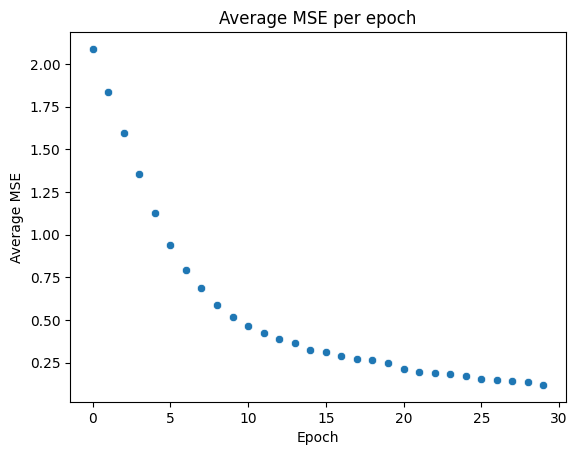

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.scatterplot(x=range(len(mses)), y=mses)
plt.title("Average MSE per epoch")
plt.xlabel("Epoch")
plt.ylabel("Average MSE")

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Accuracy')

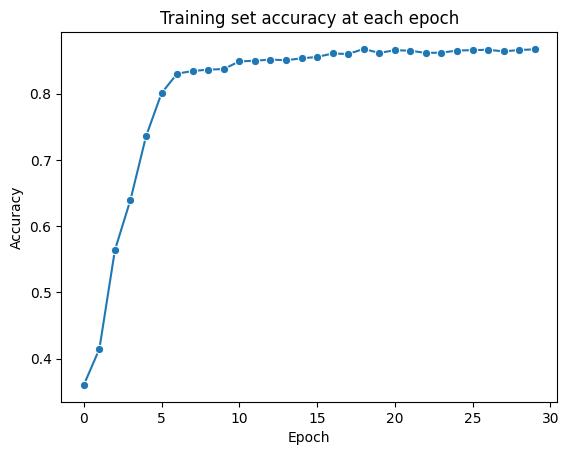

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.lineplot(x=range(len(accuracies)), y=accuracies, marker='o')
plt.title("Training set accuracy at each epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
mnist_test = torchvision.datasets.MNIST(download=True, root='./datasets/', train=False)
mnist_test_flat = mnist_test.data.view(10000, -1).to(torch.float32)

In [ ]:
mnist_test.data.shape

torch.Size([10000, 28, 28])

In [ ]:
mnist_test_flat.shape

torch.Size([10000, 784])

In [ ]:
preds = []
for sample in mnist_test_flat:
    preds.append(network.predict(sample))

In [ ]:
pred_tensor =  torch.reshape(torch.tensor(preds), (-1,1))

In [ ]:
correct = 0
for index, pred in enumerate(preds):
    if int(mnist_test.targets[index]) == pred:
        correct += 1

print(correct/len(preds))

0.8645


In [906]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class PytorchNet(nn.Module):
    def __init__(self):
        super(PytorchNet, self).__init__()
        self.layer1 = nn.Linear(784, 200, bias=False)
        self.layer2 = nn.Linear(200, 10, bias=False)

    def forward(self, x):
        x = F.sigmoid(self.layer1(x))
        return F.log_softmax(self.layer2(x))

In [875]:
n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5

In [876]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [887]:
network = PytorchNet()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0.0)

In [878]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [879]:
def train():
  network.train()
  for data, target in train_loader:
    optimizer.zero_grad()
    output = network(torch.reshape(data, (batch_size_train, -1)))
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

In [880]:
train_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [881]:
train_accs = []
for epoch in range(n_epochs):
    train()
    with torch.no_grad():
        correct = 0
        for data, target in train_loader:
            output = network(torch.reshape(data, (batch_size_train, -1)))
            pred = torch.argmax(output.data, dim=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        train_accs.append(100. * correct / len(train_loader.dataset))

C:\Users\johng\AppData\Local\Temp\ipykernel_32800\3662341025.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.layer2(x))


In [882]:
train_accs_list = [int(train_acc) for train_acc in train_accs]

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Accuracy')

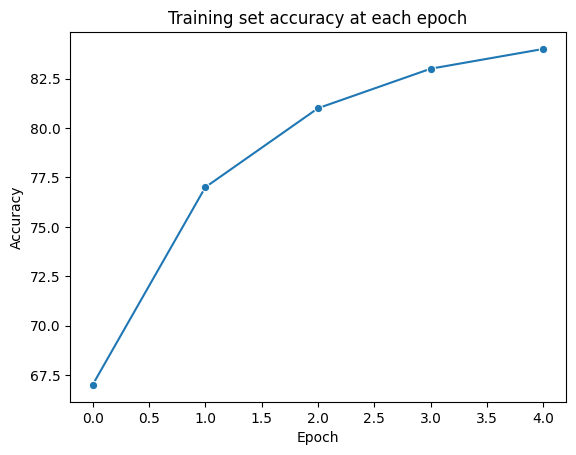

In [883]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.lineplot(x=range(len(train_accs_list)), y=train_accs_list, marker='o')
plt.title("Training set accuracy at each epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [884]:
test_accs = []
with torch.no_grad():
        correct = 0
        for data, target in test_loader:
            output = network(torch.reshape(data, (batch_size_test, -1)))
            pred = torch.argmax(output.data, dim=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_accs.append(100. * correct / len(test_loader.dataset))

C:\Users\johng\AppData\Local\Temp\ipykernel_32800\3662341025.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.layer2(x))


In [885]:
print(test_accs)

[tensor(85.7000)]


In [904]:
def train_vary_batches(batch, network, train_loader, optimizer):
  for data, target in train_loader:
      try:
        optimizer.zero_grad()
        output = network(torch.reshape(data, (batch, 784)))
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
      except:
          continue
  return network

In [907]:
train_accs = []
batch_sizes = [32, 64, 128, 256]
for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/datasets/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                                ])),
    batch_size=batch_size, shuffle=True)

    network = PytorchNet()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0.0)
    for epoch in range(n_epochs):
        network = train_vary_batches(batch_size, network, train_loader, optimizer)
   
    test_accs = []
    with torch.no_grad():
        correct = 0
        for data, target in test_loader:
            output = network(torch.reshape(data, (batch_size_test, -1)))
            pred = torch.argmax(output.data, dim=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_accs.append(100. * correct / len(test_loader.dataset))
    print(test_accs[0], batch_size)

C:\Users\johng\AppData\Local\Temp\ipykernel_32800\3612548321.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.layer2(x))


tensor(89.3600) 32
tensor(86.4100) 64
tensor(79.9200) 128
tensor(68.2800) 256
